# Général

In [1]:
import json
import glob
import xml.etree.ElementTree as ET
import tweepy
from bs4 import BeautifulSoup
import re
from nltk.tag import StanfordPOSTagger
import os
import pandas as pd

def write_json(chemin,contenu):
    with open (chemin, "w", encoding="utf-8") as w:
        w.write(json.dumps(contenu, indent=2, ensure_ascii=False))
        
def ouvrir_json(chemin) :
    with open(chemin,encoding="utf-8") as f :
        toto = json.load(f)
    return toto

C:\Users\phisi\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Extraction des corpus : constitution de corpus équilibrés

In [2]:
#https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9
#constitution du corpus de tweets : utilisation de Twitter API
def traitements_tweets(bearer_token,req,nom_fichier) :
    ''' Fonction d'extraction de tweets qui renvoie un fichier de tweets'''
    tweets = []
    nb_mots = 0
    client = tweepy.Client(bearer_token=bearer_token)
    for tweet in tweepy.Paginator(client.search_recent_tweets, query=req,
                                  tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1700):
        tweets.append(tweet.text)
        nb_mots+=len(tweet.text.split())
    
    print("Nombre de tweets : ",len(tweets))
    print("Nombre de mots : ",nb_mots)

    write_json(nom_fichier,tweets)
    
    return tweets 

In [3]:
#constitution du corpus d'articles d'Europresse
def traitement_articles(fichier) :
    '''Fonction qui permet de sauvegarder le corpus d'articles dans une liste  '''
    #utilisation de la librairie ElementTree
    tree = ET.parse(fichier)
    root = tree.getroot()
    articles = []
    nb_mots = 0
    cpt = 0
    #on cherche les balises 'article'
    for r in root.iter('article') :
        #on récupère le contenu de l'article
        articles.append(r.text)
        #on compte le nombre de mots total (tous articles réunis)
        nb_mots+=len(r.text.split())
        cpt+=1
        #print(cpt)
        if cpt== 19 :
            break
    #on stocke la liste obtenue dans un fichier json
    #write_json("articles.txt",articles)
    
    print("Nombre de mots : ",nb_mots)
    print("Nombre d'articles : ",len(articles))
    
    return articles

In [4]:
#constitution du corpus de transcriptions
def traitement_transcriptions(dossier):
    ''' Fonction qui permet de sauvegarder le corpus de transcriptions dans une liste '''
    nb_mots = 0
    transcriptions = []
    for fichier in glob.glob("%s/*"%dossier):
        with open(fichier, 'r', encoding="utf-8") as f:
            file = f.read() 

        soup = BeautifulSoup(file, 'xml')
        turns = soup.find_all('Turn')
        #chaîne où l'on stocke tout le contenu de la transcription (1 fichier = 1 item de la liste, on met bout à bout les contenus des balises turn)
        transcription = ""
        for turn in turns:
            #print(turn.text)
            transcription +=re.sub("\n"," ",turn.text)
        nb_mots+=len(transcription.split())
        transcriptions.append(transcription)
    
    print("Nombre de mots : ",nb_mots)
    print("Nombre de transcriptions : ",len(transcriptions))
    
#     write_json("transcriptions.txt",transcriptions)
    
    return transcriptions

In [5]:
def traitement_discours(fichier_discours):    
    
    '''Fonction qui permet de sauvegarder le corpus de discours politiques dans une liste'''
    
    with open(fichier_discours, 'r', encoding="utf-8") as f:
        file = f.read() 

    liste_discours = file.split("****")
    liste_discours.pop(0) #sinon 1er élément est vide
    nb_mots = len(file.split())
    nb_discours = len(liste_discours)
    
    print("Nombre de mots : ",nb_mots)
    print("Nombre de discours : ",len(liste_discours))
        
    return liste_discours

In [6]:
def traitement_discours40k(fichier_discours):   
    
    ''' Fonction d'équilibrage du corpus de discours (40 000 tokens )'''
    
    with open(fichier_discours, 'r', encoding="utf-8") as f:
        file = f.read() 

    nb_mots = 0
    liste_discours = file.split("****")
    liste_discours40k = []
    for discours in liste_discours : 
        nb_mots+= len(discours.split())
        if nb_mots<=40000:
            liste_discours40k.append(discours)
        else:
            break
    nb_discours = len(liste_discours)
    
    print("Nombre de mots : ",nb_mots)
    print("Nombre de discours : ",len(liste_discours40k))
    
    #write_json("transcriptions.txt",transcriptions)
    
    return liste_discours40k

In [7]:
liste_tweets = ouvrir_json("corpus/1700tweets.txt")
#print(liste_tweets)

In [8]:
liste_articles = traitement_articles('corpus/europresse_film.xml')
# print(liste_articles)

Nombre de mots :  40381
Nombre d'articles :  19


In [9]:
liste_transcriptions = traitement_transcriptions("corpus/corpus_transcriptions")
# print(liste_transcriptions)

Nombre de mots :  39219
Nombre de transcriptions :  45


In [10]:
liste_discours = traitement_discours("corpus/Campagne2022.txt")
print("-"*100)
liste_discours40k = traitement_discours40k("corpus/Campagne2022.txt")
print("-"*100)
liste_discours6 = traitement_discours("corpus/Campagne2022_6discours.txt")

Nombre de mots :  564320
Nombre de discours :  115
----------------------------------------------------------------------------------------------------
Nombre de mots :  46762
Nombre de discours :  6
----------------------------------------------------------------------------------------------------
Nombre de mots :  41507
Nombre de discours :  6


In [11]:
#statistiques sur les corpus
def vocabulaire(corpus):
    dico_vocab = {}
    for el in corpus:
        el = re.sub(r'[^\w]',' ', el)
        tokens = el.split()
        for t in tokens:
            if t not in dico_vocab:
                dico_vocab[t]=0
            dico_vocab[t]+=1
    return dico_vocab

print("Pour les articles : ")
voc_articles = vocabulaire(liste_articles)
print("Nombre tokens : ", sum(voc_articles.values()))
print("Nombre types : ", len(voc_articles))
print("\n************************************************")

print("Pour les tweets : ")
voc_tweets = vocabulaire(liste_tweets)
print("Nombre tokens : ", sum(voc_tweets.values()))
print("Nombre types : ", len(voc_tweets))
print("\n************************************************")

print("Pour les transcriptions")
voc_transcriptions = vocabulaire(liste_transcriptions)
print("Nombre tokens : ", sum(voc_transcriptions.values()))
print("Nombre types : ", len(voc_transcriptions))
print("\n************************************************")

Pour les articles : 
Nombre tokens :  42530
Nombre types :  8381

************************************************
Pour les tweets : 
Nombre tokens :  42485
Nombre types :  7004

************************************************
Pour les transcriptions
Nombre tokens :  42308
Nombre types :  3004

************************************************


# Recherche de marques d'oralité et de non oralité

## Calcul du nombre de marques d'oralité

In [12]:
#script de calcul du nombre de marques d'oralité, par string matching

interjections = ["bon","voilà", "ouais", "hein", "ben", "bah", "euh", "heu", "ah", "ha", "alors"]
deictiques = ["maintenant", "hier", "aujourd’hui", "demain", "bientôt", "ça"," c'", "y", "là", "ici"]
personnes = ["je","j'","t","tu"]

oralite = interjections+deictiques+personnes
dico_oralite = {}

corpus = {"transcriptions":liste_transcriptions, "articles":liste_articles,"tweets":liste_tweets}
             
for nom,liste in corpus.items():
    dico_oralite[nom]={}
    for el in liste:
        chaine_l = el.lower()
        chaine_l_propre = chaine_l.split()
        for mot in chaine_l_propre:
            for marque in oralite:
                if mot==marque:
                    if marque not in dico_oralite[nom]:
                        dico_oralite[nom][marque]=0
                    dico_oralite[nom][marque]+=1
                

for key, value in dico_oralite.items():
    print(key,value, "\n")
    print(sorted(value.items(), key=lambda x:x[1],reverse=True), "\n")
    print(sum(value.values()), "\n")
    print("****************")

transcriptions {'ça': 541, 'alors': 153, 'euh': 1529, 'je': 586, 'voilà': 242, 'bon': 179, 'ouais': 479, 'maintenant': 32, 'y': 299, 'bah': 372, 'ben': 32, 'ici': 17, 'hein': 158, 'là': 127, 'ah': 236, 'tu': 88, 'hier': 1, 'bientôt': 4, 'demain': 5} 

[('euh', 1529), ('je', 586), ('ça', 541), ('ouais', 479), ('bah', 372), ('y', 299), ('voilà', 242), ('ah', 236), ('bon', 179), ('hein', 158), ('alors', 153), ('là', 127), ('tu', 88), ('maintenant', 32), ('ben', 32), ('ici', 17), ('demain', 5), ('bientôt', 4), ('hier', 1)] 

5080 

****************
articles {'je': 279, 'ça': 75, 'là': 23, 'alors': 36, 'y': 118, 'ici': 8, 'tu': 16, 'ben': 3, 'bon': 7, 'bientôt': 2, 'voilà': 2, 'ah': 1, 'demain': 1} 

[('je', 279), ('y', 118), ('ça', 75), ('alors', 36), ('là', 23), ('tu', 16), ('ici', 8), ('bon', 7), ('ben', 3), ('bientôt', 2), ('voilà', 2), ('ah', 1), ('demain', 1)] 

571 

****************
tweets {'je': 215, 'ça': 99, 'hier': 11, 'y': 140, 'tu': 52, 'ah': 5, 'là': 40, 'alors': 26, 'mainten

In [13]:
def bigrammes_gauche(mot_cherche,corpus):
    
    ''' Fonction qui renvoie la fréquence d'un token à gauche du mot cherché, selon le corpus choisi '''
    
    dico = {}
    for el in corpus:
        el = re.sub(r'[^\w]',' ', el)
        tokens = el.split()
        chaine = ""
        for i,n in enumerate(tokens):
            if mot_cherche == n :
                if i > 0 :
                    chaine+=tokens[i-1]+" "+n
                    if chaine not in dico :
                        dico[chaine] = 0
                    dico[chaine] += 1

    return dico
                

In [14]:
def bigrammes_droite(mot_cherche,corpus):
    
    ''' Fonction qui renvoie la fréquence d'un token à droite du mot cherché, selon le corpus choisi '''
    
    dico = {}
    for el in corpus:
        el = re.sub(r'[^\w]',' ', el)
        tokens = el.split()
        chaine = ""
        for i,n in enumerate(tokens):
            if mot_cherche == n :
                if i < len(tokens)-1 :
                    chaine += n+" "+tokens[i+1]
                    if chaine not in dico :
                        dico[chaine] = 0
                    dico[chaine] += 1

    return dico


In [15]:
bigrammes_gauche("bon",liste_articles)

bigrammes_droite("bon",liste_articles)

bigrammes_gauche("bon",liste_tweets)

#bigrammes_droite("bon",liste_tweets)

{'est bon': 1,
 'un bon': 4,
 'si bon': 1,
 'trop bon': 1,
 'au bon': 1,
 'ce bon': 2,
 'mais bon': 3,
 'très bon': 3,
 '1 bon': 1,
 'pas bon': 1}

## Calcul du nombre de marques de non oralité

In [16]:
#script de calcul du nombre de marques de non oralité, par string matching

non_oralite = ["n","ne","cela","car","dont","tant","pourtant","son","ses","sa","il","lui","se"]
dico_non_oralite = {}
corpus = {"transcriptions":liste_transcriptions, "articles":liste_articles,"tweets":liste_tweets}
             
for nom,liste in corpus.items():
    dico_non_oralite[nom]={}
    for el in liste:
        chaine_l = el.lower()
        #chaine_l_propre = re.sub(r'[^\w]',' ', chaine_l)
        chaine_l_propre = chaine_l.split()
        for mot in chaine_l_propre:
            for marque in non_oralite:
                if mot==marque:
                    if marque not in dico_non_oralite[nom]:
                        dico_non_oralite[nom][marque]=0
                    dico_non_oralite[nom][marque]+=1
                
# sorted(dico_oralite.items(), key=lambda x:x[1],reverse=True)
for key, value in dico_non_oralite.items():
    print(key,value, "\n")
    print(sorted(value.items(), key=lambda x:x[1],reverse=True), "\n")
    print(sum(value.values()), "\n")
    print("****************")

transcriptions {'il': 276, 'se': 109, 'son': 39, 'lui': 32, 'sa': 30, 'ne': 67, 'dont': 9, 'ses': 10, 'cela': 3, 'pourtant': 1} 

[('il', 276), ('se', 109), ('ne', 67), ('son', 39), ('lui', 32), ('sa', 30), ('ses', 10), ('dont', 9), ('cela', 3), ('pourtant', 1)] 

576 

****************
articles {'se': 188, 'ne': 200, 'sa': 151, 'il': 426, 'ses': 106, 'car': 25, 'cela': 46, 'tant': 19, 'pourtant': 10, 'son': 235, 'dont': 53, 'lui': 76} 

[('il', 426), ('son', 235), ('ne', 200), ('se', 188), ('sa', 151), ('ses', 106), ('lui', 76), ('dont', 53), ('cela', 46), ('car', 25), ('tant', 19), ('pourtant', 10)] 

1535 

****************
tweets {'son': 70, 'il': 231, 'ne': 57, 'ses': 38, 'se': 64, 'dont': 15, 'tant': 6, 'sa': 31, 'lui': 19, 'cela': 26, 'car': 9, 'pourtant': 4, 'n': 1} 

[('il', 231), ('son', 70), ('se', 64), ('ne', 57), ('ses', 38), ('sa', 31), ('cela', 26), ('lui', 19), ('dont', 15), ('car', 9), ('tant', 6), ('pourtant', 4), ('n', 1)] 

571 

****************


# Détection des phrases négatives (écrit VS oral)

In [17]:
#à faire : ne...jamais
def marques_negation(corpus) :  
    #https://stackoverflow.com/questions/977251/regular-expressions-and-negating-a-whole-character-group
    
    ''' Fonction qui détecte les phrases négatives et renvoie le nombre d'occurrences 
    des phrases négatives considérées orales ou écrites '''

    neg_ecrit = 0
    neg_oral = 0
    for c in corpus :
        
        #exclusion du nom pas en considerant que pas est un nom s'il est précédé d'un article
        motif_pas_nom = re.compile(r'.*?((le[s]?\spas) |(aux?\spas) | (un\spas) | (de[s]?\spas) | ([mts](on|es)\spas) | ([nv](os | otres)\spas) | (leurs?\spas) | (ces?\spas))')
        
        
        
        #recherche du motif de la forme : ne | n' ... pas
        negation_avec_ne_pas = re.compile(r'.*?([nN]e\s | n[\'\’])(?:(?!\.).)+?(pas[\s\W])')


        #recherche du motif de la forme : ne | n' ... plus
        negation_avec_ne_plus = re.compile(r'.*?([nN]e\s | n[\'\’])(?:(?!\.).)+?(plus[\s\W])')

        
        #recherche du motif de négation à l'oral: pas sans ne ou n'
        negation_sans_ne = re.compile(r'(?:(?![nN]e\s).)+?(pas[\s\W])')
        negation_sans_n = re.compile(r'(?:(?![nN][\’|\']).)+?(pas[\s\W])')
        

        #négations classiques à l'écrit
        neg_ne_pas = re.match(negation_avec_ne_pas,c)
        neg_ne_plus = re.match(negation_avec_ne_plus,c)

        if not re.match(motif_pas_nom,c) :
            if neg_ne_pas :
                neg_ecrit+=1
#                 print("Ecrit")
#                 print(c)
#                 print(neg_ne_pas.group(0))
#                 print("-"*55)

            #cas de la marque (ne...) plus : plus a un autre sens, n'exprime pas uniquement la négation > risque de bruit   
            if neg_ne_plus :
                neg_ecrit+=1
#                 print("Ecrit")
#                 print(neg_ne_plus.group(0))
#                 print(c)
#                 print("-"*55)

            neg_sans_ne = re.match(negation_sans_ne,c)
            neg_sans_n = re.match(negation_sans_n,c)
            #négation à l'oral :
            if neg_sans_ne and neg_sans_n:
                neg_oral+=1
#                 print("Oral")
#                 print(neg_sans_ne.group(0))
#                 print(c)
#                 print("*"*55)

    #print("Négation ne pas : ",neg_ecrit)
    #print("Négation à l'oral : ",neg_oral)
    return neg_ecrit,neg_oral

In [18]:
marques_negation(liste_tweets)

(32, 89)

In [19]:
def marques_negation_transcriptions(corpus) :
    ''' Fonction qui calcule le nombre d'occurences des phrases négatives écrites ou orales 
    pour le corpus de transcriptions '''
    
    neg_ecrit = 0
    neg_oral = 0
    for c in corpus :
        sequences = c.split('    ')
        cpt_ecrit,cpt_oral = marques_negation(sequences)
        neg_ecrit+=cpt_ecrit
        neg_oral+=cpt_oral
        #print(phrases)
    return neg_ecrit,neg_oral
marques_negation_transcriptions(liste_transcriptions)

(51, 280)

In [20]:
def marques_negation_articles(corpus) :
    
    ''' Fonction qui calcule le nombre d'occurences des phrases négatives écrites ou orales pour le corpus d'articles '''
    
    neg_ecrit = 0
    neg_oral = 0
    cpt_ecrit = 0
    cpt_oral = 0
    for c in corpus :
        phrases = c.split(".")
        cpt_ecrit,cpt_oral = marques_negation(phrases)
        neg_ecrit+=cpt_ecrit
        neg_oral+=cpt_oral
        #print(phrases)
    return neg_ecrit,neg_oral


In [21]:
marques_negation_articles(liste_articles)

(137, 19)

# Calcul du degré oralité de chaque corpus

In [22]:
def frequence_marques(marques,cEcrit,cOral,autre) :
    
    ''' Fonction de calcul de la fréquence des marques d'oralité et de non oralité '''
    
    dico_non_oralite = {}
    corpus = {"oralite":cOral, "ecrit":cEcrit,"autre":autre}

    for nom,liste in corpus.items():
        dico_non_oralite[nom]={}
        for el in liste:
            chaine_l = el.lower()
            #chaine_l_propre = re.sub(r'[^\w]',' ', chaine_l)
            chaine_l_propre = chaine_l.split()
            for mot in chaine_l_propre:
                for marque in marques:
                    if mot==marque:
                        if marque not in dico_non_oralite[nom]:
                            dico_non_oralite[nom][marque]=0
                        dico_non_oralite[nom][marque]+=1
   
    return dico_non_oralite["oralite"],dico_non_oralite["ecrit"],dico_non_oralite["autre"]

In [23]:
def calcul_marques(marques_oral,marques_ecr,corp_ecrit,corp_oral,autre) :
    
    ''' Fonction qui calcule le pourcentage de chaque marque orale/écrite par rapport au nombre total
    
    de marques de l'oral/écrit '''
    
    oralO = frequence_marques(marques_oral,corp_ecrit,corp_oral,autre)[0]
    ecrO = frequence_marques(marques_ecr,corp_ecrit,corp_oral,autre)[1]
   
    dic_coeff_O = {}
    total_or = sum(oralO.values())
    for k,v in oralO.items() :
        dic_coeff_O[k] = round((v*100)/total_or,3)
    dic_coeff_E = {}
    total_E = sum(ecrO.values())
    for k,v in ecrO.items() :
        #multiplication des marques de l'écrit par -1 pour les opposer aux marques de l'oral
        dic_coeff_E[k] = round((v*100)/total_E,3)*(-1)
    return dic_coeff_O,dic_coeff_E

In [24]:
dico_Oral, dico_Ecrit = calcul_marques(oralite,non_oralite,liste_articles,liste_transcriptions,liste_tweets)
print(dico_Oral, dico_Ecrit)

{'ça': 10.65, 'alors': 3.012, 'euh': 30.098, 'je': 11.535, 'voilà': 4.764, 'bon': 3.524, 'ouais': 9.429, 'maintenant': 0.63, 'y': 5.886, 'bah': 7.323, 'ben': 0.63, 'ici': 0.335, 'hein': 3.11, 'là': 2.5, 'ah': 4.646, 'tu': 1.732, 'hier': 0.02, 'bientôt': 0.079, 'demain': 0.098} {'se': -12.248, 'ne': -13.029, 'sa': -9.837, 'il': -27.752, 'ses': -6.906, 'car': -1.629, 'cela': -2.997, 'tant': -1.238, 'pourtant': -0.651, 'son': -15.309, 'dont': -3.453, 'lui': -4.951}


In [25]:
def calcul_oralite(dicoOral,dicoEcrit,corpus):
    ''' Fonction qui calcule le score d'oralité d'un corpus '''
    dico_score_oralite = {}
    for i,text in enumerate(corpus):
        dico_score_oralite[i]=0.0
        for token in text.lower().split():
            if token in dico_Oral:
                dico_score_oralite[i]+=dicoOral[token]
            if token in dico_Ecrit:
                dico_score_oralite[i]+=dicoEcrit[token]
        #print(text+" : "+str(dico_score_oralite[i]))
        #print("-"*89)
   
    return dico_score_oralite

In [26]:
scores_oralite_tweets = calcul_oralite(dico_Oral,dico_Ecrit,liste_tweets)
moy_oralite_tweets = sum(scores_oralite_tweets.values())/len(scores_oralite_tweets)
print("Moyenne de l'oralité des tweets : ",moy_oralite_tweets)

scores_oralite_transcriptions = calcul_oralite(dico_Oral,dico_Ecrit,liste_transcriptions)
moy_oralite_transcriptions = sum(scores_oralite_transcriptions.values())/len(scores_oralite_transcriptions)
print("Moyenne de l'oralité des transcriptions : ",moy_oralite_transcriptions)

scores_oralite_articles = calcul_oralite(dico_Oral,dico_Ecrit,liste_articles)
moy_oralite_articles = sum(scores_oralite_articles.values())/len(scores_oralite_articles)
print("Moyenne de l'oralité des articles : ",moy_oralite_articles)

scores_oralite_discours = calcul_oralite(dico_Oral, dico_Ecrit,liste_discours6)
moy_oralite_discours = sum(scores_oralite_discours.values())/len(scores_oralite_discours)
print("Moyenne de l'oralité des discours : ",moy_oralite_discours)

Moyenne de l'oralité des tweets :  -2.9197105882353003
Moyenne de l'oralité des transcriptions :  1352.5061555555544
Moyenne de l'oralité des articles :  -966.5706842105255
Moyenne de l'oralité des discours :  -901.3488333333329


# Etiquetage morphosyntaxique des corpus

In [27]:
def lire_txt(chemin):
    '''Fonction de recuperation de la chaine d'un fichier '''
    with open(chemin, 'r', encoding="utf-8") as f:
        file= f.read() 
    return file

In [28]:
def pos_tagging(list_text):
    
    ''' Fonction d'annotation des parties du discours d'un texte donné '''
    
    #à mettre à jour selon la machine
    #jar = 'C:/Users/fanny/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar'
    jar = 'C:/Users/phisi/stanford-tagger-4.2.0/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar'
    
    #à mettre à jour selon la machine
    #model = 'C:/Users/fanny/stanford-postagger-full-2020-11-17/models/french-ud.tagger'
    model = 'C:/Users/phisi/stanford-tagger-4.2.0/stanford-postagger-full-2020-11-17/models/french-ud.tagger'
    
    #à mettre à jour selon la machine
    #java_path = "C:/Program Files/Java/jdk-18/bin/java.exe"
    java_path = "C:/Program Files/Java/jdk-18.0.1.1/bin/java.exe"
    
    
    os.environ['JAVAHOME'] = java_path
    pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8' )
    text_tagged = pos_tagger.tag(list_text.split())
    new_text = []
    for word in text_tagged:
        new_text.append(word[0] + "/" + word[1])
    doc = ' '.join(new_text)
    return doc

In [29]:
def fichier_pos(chemin_corpus,chemin_desti):
    '''Fonction qui renvoie un fichier annoté (part of speech) de chaque corpus'''
    
    corpus = lire_txt(chemin_corpus)
    corpus_pos = pos_tagging(corpus)
    write_json(chemin_desti,corpus_pos)

In [30]:
fichier_pos("corpus/transcriptions.txt","transcriptions_pos.txt")
fichier_pos("corpus/articles.txt","articles_pos.txt")

In [31]:
fichier_pos("corpus/1700tweets.txt","1700tweets_pos.txt")
fichier_pos("corpus/Campagne2022_6discours.txt", "Campagne2022_6discours_pos.txt")

In [32]:
def dico_pos(chemin_corpus_pos):
    
    '''Fonction qui calcule le nombre d'occurrences d'une partie du discours pour chaque corpus '''
    
    corpus_pos = lire_txt(chemin_corpus_pos)
    cp = corpus_pos.split()
    dico_pos = {}
    for couple in cp:
        mot_pos = couple.split("/")
        if mot_pos[-1] not in dico_pos:
            dico_pos[mot_pos[-1]]=0
        dico_pos[mot_pos[-1]]+=1
    return dico_pos

dico_pos_articles = dico_pos("articles_pos.txt")
dico_pos_transcriptions = dico_pos("transcriptions_pos.txt")
dico_pos_tweets = dico_pos("1700tweets_pos.txt")
dico_pos_discours = dico_pos("Campagne2022_6discours_pos.txt")

In [33]:
def stats_pos(dico_pos_corpus):
    
    '''Fonction qui calcule la fréquence d'une partie du discours pour chaque corpus '''
    
    dico_stats_pos = {}
    for k,v in dico_pos_corpus.items():
        dico_stats_pos[k]= (v/sum(dico_pos_corpus.values()))*100
    return dico_stats_pos

stats_pos_articles = stats_pos(dico_pos_articles)
stats_pos_transcriptions = stats_pos(dico_pos_transcriptions)
stats_pos_tweets = stats_pos(dico_pos_tweets)
stats_pos_discours = stats_pos(dico_pos_discours)
print("Articles : ",stats_pos_articles)
print("Transcriptions : ", stats_pos_transcriptions)
print("Tweets : ", stats_pos_tweets)
print("Discours : ",stats_pos_discours)

Articles :  {'PUNCT': 2.657058663298913, 'X': 0.7800312012480499, 'ADJ': 6.854369412871753, 'NOUN': 19.61468934947874, 'DET': 13.879602803159747, 'VERB': 13.054998390411807, 'PRON': 7.604685139786543, 'AUX': 3.090409330658941, 'ADP': 12.755367357551444, 'NUM': 1.3693881088576876, 'ADV': 5.163063665403759, 'CCONJ': 2.825446351187381, 'PROPN': 8.902260852338856, 'INTJ': 0.022286605749944285, 'SCONJ': 1.3817695564965455, 'PART': 0.0198103162221727, 'SYM': 0.022286605749944285, 'PUNCT"': 0.0024762895277715873}
Transcriptions :  {'PUNCT': 2.1953142886215056, 'NOUN': 14.67273791050851, 'ADP': 7.829869502174963, 'PRON': 13.782401872249498, 'VERB': 14.186868815344306, 'DET': 9.249319528885044, 'ADJ': 7.43557782808883, 'SCONJ': 2.470046551855715, 'ADV': 10.424563099386939, 'NUM': 1.4499758337361044, 'X': 4.098089593243621, 'AUX': 3.764849533209534, 'PROPN': 2.0706672432652438, 'CCONJ': 3.4799420009666506, 'INTJ': 2.5616239729337846, 'SYM': 0.19078629391264532, 'PART': 0.13482231436493602, 'PUNC

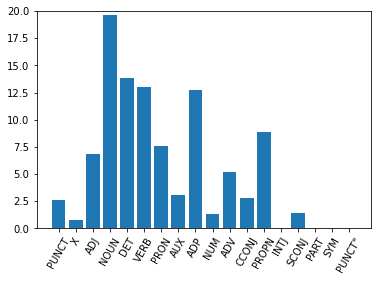

In [34]:
import matplotlib.pyplot as plt
def dict_to_bar(data,chemin_sortie):
    ''' Fonction qui représente la proportion des étiquettes morphosyntaxiques par corpus sous forme de 
    diagramme en barres'''
    
    names = list(data.keys())
    values = list(data.values())

    plt.bar(range(len(data)), values, tick_label=names)
    plt.xticks(rotation=60)
    plt.ylim(0,20)
    plt.savefig(chemin_sortie)
    plt.show()
    
dict_to_bar(stats_pos_articles, "stats_pos_articles.png")

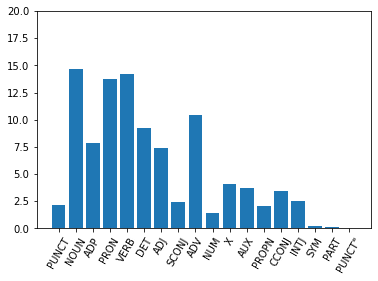

In [35]:
dict_to_bar(stats_pos_transcriptions, "stats_pos_transcriptions.png")

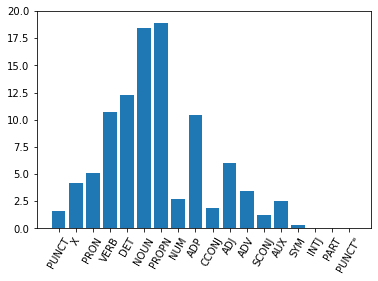

In [36]:
dict_to_bar(stats_pos_tweets, "stats_pos_tweets.png")

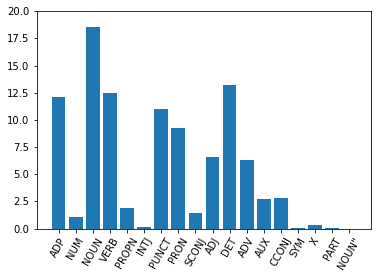

In [37]:
dict_to_bar(stats_pos_discours, "stats_pos_discours.png")